# Simulations

Simulate four different scenarios in which an epidemic spreads across a population of susceptibles. Run each simulation 20 times. Collect the infection attack rate and the length of the epidemic for each run.

### Set up

Load required packages:

In [1]:
# for modelling:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
# for plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# for hypothesis testing:
import scipy.stats as stats
# for pretty printing
from IPython.display import display_html

Since the SEIR model characterised by ODEs, we will be using [Scipy's solve_ivp() function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to track the progression of the epidemic. 

Given a vector 'y', whose elements correspond to the number of individuals in the susceptible, exposed, infectious, recovered, singly vaccinated and doubly vaccinated compartments, we define a function that calculates the transition rates between the compartments at time t.

The function generates a vector of transition rates based on the equations we provide (for the logic behind the equations, please refer to the project report)

In [2]:
# Create a vector containing the equations for the transition rates for the scenarios without vaccinations:
def transition_rates_base(t, y, beta, sigma, gamma): # y is a vector containing values of s, e, i and r
    s = y[0]; e = y[1]; i = y[2]; r = y[3]
    dydt = np.array([-beta*i*s/N, 
                     beta*i*s/N - sigma*e, 
                     sigma*e - gamma*i, 
                     gamma*i]) # use parameters to supply rates of change
    return dydt
# Create a vector containing the equations for the transition rates for the scenrios with vaccinations:
def transition_rates_vax(t, y, beta, sigma, gamma, mu, eta, psi, N): # y == vector, contains values of s, e, i, r, v1 and v2
    s = y[0]; e = y[1]; i = y[2]; r = y[3]; v1 = y[4]; v2 = y[5]
    dydt = np.array( [-beta*i*s/N - eta*s, #ds/dt
                     beta*i*s/N - sigma*e + mu*v1*i/N, #de/dt
                     sigma*e - gamma*i, #di/dt
                     gamma*i + psi*v1, #dr/dt
                     eta*s - mu*v1*i/N - psi*v1, #dv1/dt
                     psi*v1] ) #dv2/dt
    return dydt

### Simulate a natural epidemic spread
Here, we just track the progression of the pandemic. No preventative measures are assumed, including social distancing, masking, or quarantining.

In [4]:
# global epidemic spread parameters:
beta = 0.4
gamma = 0.1
sigma = 0.2
N = 1000000

# Initialize data containers
np.random.seed(79)
durations_base = [] # a list of the number of days the epidemic lasted for
iars_base = [] # a list of the total number of infected individuals during the course of the epidemic
x = 1

while x < 51: # 50 runs, same spread parameters, different starting distribution each time
    
    # initial distribution - use a PRNG to restart the simulation with different starting distributions:
    np.random.seed(np.random.randint(low = 0, high = 500))
    s = np.random.randint(low = N-50, high = N)
    y0 = [s, 0, N-s, 0]
    e = y0[1]
    i = y0[2]
    
    # Initialize recorders for last rep - these will record the number of individuals in each compartment at each time point:
    if x == 50:
        s_timeseries_base = [y0[0]]
        e_timeseries_base = [y0[1]]
        i_timeseries_base = [y0[2]]
        r_timeseries_base = [y0[3]]
    
    # Initialise variable to keep track of infection attack rate:
    attack_rate = i/N
    
    # Initialize day
    day = 0
    
    while (i+e >= 1): # epidemic terminates when number of infectious + exposed is less than 1, almost 0

        # Using Scipy's IVP solver function, solve the IVP and reshape into one dimension
        soln = solve_ivp(transition_rates_base, 
                         (day,day+1), 
                         y0, t_eval = [day+1], 
                         args = (beta, sigma, gamma))
        y_new = soln.y.reshape((4,))
        
        # update time series trackers
        if x == 50:
            s_timeseries_base.extend([y_new[0]])
            e_timeseries_base.extend([y_new[1]])
            i_timeseries_base.extend([y_new[2]])
            r_timeseries_base.extend([y_new[3]])
        
        # update infection attack rate
        if y_new[2] > y0[2]:
            attack_rate += (soln.y[2] - y0[2])/N

        # update initial condition
        y0 = y_new 

        # update e and i for terminating condition
        e = y0[1] 
        i = y0[2]

        # Move to the next day
        day = soln.t[0] 
        
    # store outputs
    iars_base.append(attack_rate[0])
    durations_base.append(day+1)
    
    # next replication
    x += 1
    
evolution_base = pd.DataFrame({'S': s_timeseries_base, 
                                   'E': e_timeseries_base, 
                                   'I': i_timeseries_base, 
                                   'R': r_timeseries_base})

### Simulate an epidemic spread with some preventative behaviours
Here, we simulate the progression of an epidemic, if individuals in the population engage in preventative behavious such as masking, social distancing and quarantining.

Masking and social distancing would reduce the transmission probability upon contact between an infected individual and a susceptible individual. Quarantining would reduce the average contact rate of the population. Together, these measures will reduce the beta value associated with the disease spread.

In [5]:
# global epidemic spread parameters:
beta = 0.3
gamma = 0.1
sigma = 0.2
N = 1000000

# Initialize data containers
np.random.seed(79)
durations_prev = [] # a list of the number of days the epidemic lasted for
iars_prev = [] # a list of the total number of infected individuals during the course of the epidemic
ts_prev = [] # a list of dataframes containing the s,e,i,r distribution for each day
x = 1

while x < 51: # 50 runs, same spread parameters, different starting distribution each time
    
    # initial distribution - use a PRNG to restart the simulation with different starting distributions:
    np.random.seed(np.random.randint(low = 0, high = 500))
    s = np.random.randint(low = N-50, high = N)
    y0 = [s, 0, N-s, 0,]
    e = y0[1]
    i = y0[2]
    
    
    # Initialize recorders - these will record the number of individuals in each compartment at each time point:
    if x == 50:
        s_timeseries_prev = [y0[0]]
        e_timeseries_prev = [y0[1]]
        i_timeseries_prev = [y0[2]]
        r_timeseries_prev = [y0[3]]
    
    # Initialise variable to keep track of infection attack rate:
    attack_rate = i/N
    
    # Initialize day
    day = 0
    
    while (i+e >= 1): # epidemic terminates when number of infectious + exposed is less than 1, almost 0

        # Using Scipy's IVP solver function, solve the IVP and reshape into one dimension
        soln = solve_ivp(transition_rates_base, 
                         (day,day+1), 
                         y0, 
                         t_eval = [day+1], 
                         args = (beta, sigma, gamma))
        y_new = soln.y.reshape((4,))

        # update time series trackers
        if x == 50:
            s_timeseries_prev.extend([y_new[0]])
            e_timeseries_prev.extend([y_new[1]])
            i_timeseries_prev.extend([y_new[2]])
            r_timeseries_prev.extend([y_new[3]])
        
        # update infection attack rate
        if y_new[2] > y0[2]:
            attack_rate += (soln.y[2] - y0[2])/N

        # update initial condition
        y0 = y_new 

        # update e and i for terminating condition
        e = y0[1] 
        i = y0[2]

        # Move to the next day
        day = soln.t[0] 
        
    # store outputs
    iars_prev.append(attack_rate[0])
    durations_prev.append(day+1)
    
    x += 1
    
evolution_prev = pd.DataFrame({'S': s_timeseries_prev, 
                                   'E': e_timeseries_prev, 
                                   'I': i_timeseries_prev, 
                                   'R': r_timeseries_prev})

### Simulate vaccination strategy A
Here, we build on the preventative behaviours by adding vaccinations to the mix. For an individual to be considered fully vaccinated, and thus immune, they must receive two doses of the vaccine.

Start by giving everybody a single dose of the vaccine. Once the number of singly vaccinated, recovered and infected individuals exceeds 70% (the assumed threshold for herd immunity), we start giving all singly vaccinated individuals a second dose.

In [6]:
# global epidemic spread parameters:
beta = 0.3
gamma = 0.1
sigma = 0.2
N = 1000000

# Initialize data containers
np.random.seed(79)
durations_vA = [] # a list of the number of days the epidemic lasted for
iars_vA = [] # a list of the total number of infected individuals during the course of the epidemic
ts_vA = [] # a list of dataframes containing the s,e,i,r distribution for each day
x = 1

while x < 51: # 50 runs, same spread parameters, different starting distribution each time
    
    # initial distribution - use a PRNG to restart the simulation with different starting distributions:
    np.random.seed(np.random.randint(low = 0, high = 500))
    S = np.random.randint(low = N-50, high = N)
    y0 = np.array([S, 0, N-S, 0, 0, 0])
    E = y0[1]
    I = y0[2]
    R = y0[3]
    V1 = y0[4]
    V2 = y0[5]
    
    # Initialize recorders - these will record the number of individuals in each compartment at each time point:
    if x == 50:
        s_timeseries_vA = [y0[0]] # record susceptibles
        e_timeseries_vA = [y0[1]] # record exposed
        i_timeseries_vA = [y0[2]] # record infectious
        r_timeseries_vA = [y0[3]] # record removed
        v1_timeseries_vA = [y0[4]] # record partially vaccinated
        v2_timeseries_vA = [y0[5]] # record fully vaccinated

    # Initialise variable to keep track of infection attack rate:
    attack_rate = I/N
    
    # Initialize day
    day = 0
    
    while (I+E >= 1): # epidemic terminates when number of infectious + exposed is less than 1, ie, there is no infected/exposed individual

       # Vaccination: start delivering dose 1 once the number of infected people represents 1% of the population 
        if I/N < 0.01:
            mu = 0
            eta = 0
            psi = 0  
        else:
            mu = 0.40*beta
            eta = 0.008
        
        # Vaccination: start delivering dose 2 once 70% of the population is either infected, immune, or has received the first dose
        if (V1+I+R)/N < 0.7:
            psi = 0
        else:
            psi = 0.007
            
         # Using Scipy's IVP solver function, solve the IVP and reshape into one dimension
        soln = solve_ivp(transition_rates_vax, 
                         (day,day+1), 
                         y0, 
                         t_eval = [day+1], 
                         args = (beta, sigma, gamma, mu, eta, psi, N))
        y_new = soln.y.reshape((6,))

        # update time series trackers
        if x == 50:
            s_timeseries_vA.extend([y_new[0]])
            e_timeseries_vA.extend([y_new[1]])
            i_timeseries_vA.extend([y_new[2]])
            r_timeseries_vA.extend([y_new[3]])
            v1_timeseries_vA.extend([y_new[4]])
            v2_timeseries_vA.extend([y_new[5]])
        
        # update infection attack rate
        if y_new[2] > y0[2]:
            attack_rate += (soln.y[2] - y0[2])/N

        # update initial condition
        y0 = y_new 

        # update e and i for terminating condition, and v1 for starting second dose
        E = y0[1] 
        I = y0[2]
        R = y0[3]
        V1 = y0[4]

        # Move to the next day
        day = soln.t[0] 
        
    # store outputs
    iars_vA.append(attack_rate[0])
    durations_vA.append(day+1)
    
    x += 1
    
evolution_vA = pd.DataFrame({'S': s_timeseries_vA, 
                                 'E': e_timeseries_vA, 
                                 'I': i_timeseries_vA, 
                                 'R': r_timeseries_vA, 
                                 'V1': v1_timeseries_vA, 
                                 'V2': v2_timeseries_vA})

### Simulate vaccination strategy B
Here also, we build on the preventative behaviours by adding vaccinations to the mix. However, this time we follow a different vaccination strategy. Still, for an individual to be considered fully vaccinated, and thus immune, they must receive two doses of the vaccine.

In this case, every individual who receives a single dose of the vaccine also receives a second dose after a standard delay of 5 days.

In [7]:
# global epidemic spread parameters:
beta = 0.3
gamma = 0.1
sigma = 0.2
N = 1000000

# Initialize data containers
np.random.seed(79)
durations_vB = [] # a list of the number of days the epidemic lasted for
iars_vB = [] # a list of the total number of infected individuals during the course of the epidemic
ts_vB = [] # a list of dataframes containing the s,e,i,r distribution for each day
x = 1

while x < 51: # 50 runs, same spread parameters, different starting distribution each time
    
    # initial distribution - use a PRNG to restart the simulation with different starting distributions:
    np.random.seed(np.random.randint(low = 0, high = 500))
    S = np.random.randint(low = N-50, high = N)
    y0 = np.array([S, 0, N-S, 0, 0, 0])
    E = y0[1]
    I = y0[2]
    R = y0[3]
    V1 = y0[4]
    V2 = y0[5]
    
    # Initialize recorders - these will record the number of individuals in each compartment at each time point:
    if x == 50:
        s_timeseries_vB = [y0[0]] # record susceptibles
        e_timeseries_vB = [y0[1]] # record exposed
        i_timeseries_vB = [y0[2]] # record infectious
        r_timeseries_vB = [y0[3]] # record removed
        v1_timeseries_vB = [y0[4]] # record partially vaccinated
        v2_timeseries_vB = [y0[5]] # record fully vaccinated
    
    # Initialise variable to keep track of infection attack rate:
    attack_rate = I/N
    
    # Initialize day
    day = 0
    
    while (I+E >= 1): # epidemic terminates when number of infectious + exposed is less than 1, ie, there is no infected/exposed individual

       # Vaccination: start delivering dose 1 once 1% of the population is infected, and the second dose 5 days later
        if I/N < 0.01:
                mu = 0
                eta = 0
                psi = 0 
                start_day = day + 1
        else:
            mu = 0.40*beta
            eta = 0.008
            psi = 0
            
            if day > start_day + 5:
                mu = 0.40*beta
                eta = 0.008
                psi = 0.008
            
         # Using Scipy's IVP solver function, solve the IVP and reshape into one dimension
        soln = solve_ivp(transition_rates_vax, 
                         (day,day+1), 
                         y0, 
                         t_eval = [day+1], 
                         args = (beta, sigma, gamma, mu, eta, psi, N))
        y_new = soln.y.reshape((6,))
        
        # update time series trackers
        if x == 50:
            s_timeseries_vB.extend([y_new[0]])
            e_timeseries_vB.extend([y_new[1]])
            i_timeseries_vB.extend([y_new[2]])
            r_timeseries_vB.extend([y_new[3]])
            v1_timeseries_vB.extend([y_new[4]])
            v2_timeseries_vB.extend([y_new[5]])
        
        # update infection attack rate
        if y_new[2] > y0[2]:
            attack_rate += (soln.y[2] - y0[2])/N

        # update initial condition
        y0 = y_new 

        # update e and i for terminating condition, and v1 for starting second dose
        E = y0[1] 
        I = y0[2]
        R = y0[3]
        V1 = y0[4]

        # Move to the next day
        day = soln.t[0] 
        
    # store outputs
    iars_vB.append(attack_rate[0])
    durations_vB.append(day+1)
    
    x += 1
    
evolution_vB = pd.DataFrame({'S': s_timeseries_vB, 
                               'E': e_timeseries_vB, 
                               'I': i_timeseries_vB,
                               'R': r_timeseries_vB, 
                               'V1': v1_timeseries_vB, 
                               'V2': v2_timeseries_vB})

## Output

While runnig the simulations, I recorded the progression of the epidemic for the last replicate. Let's plot it for each of the four scenarios.  

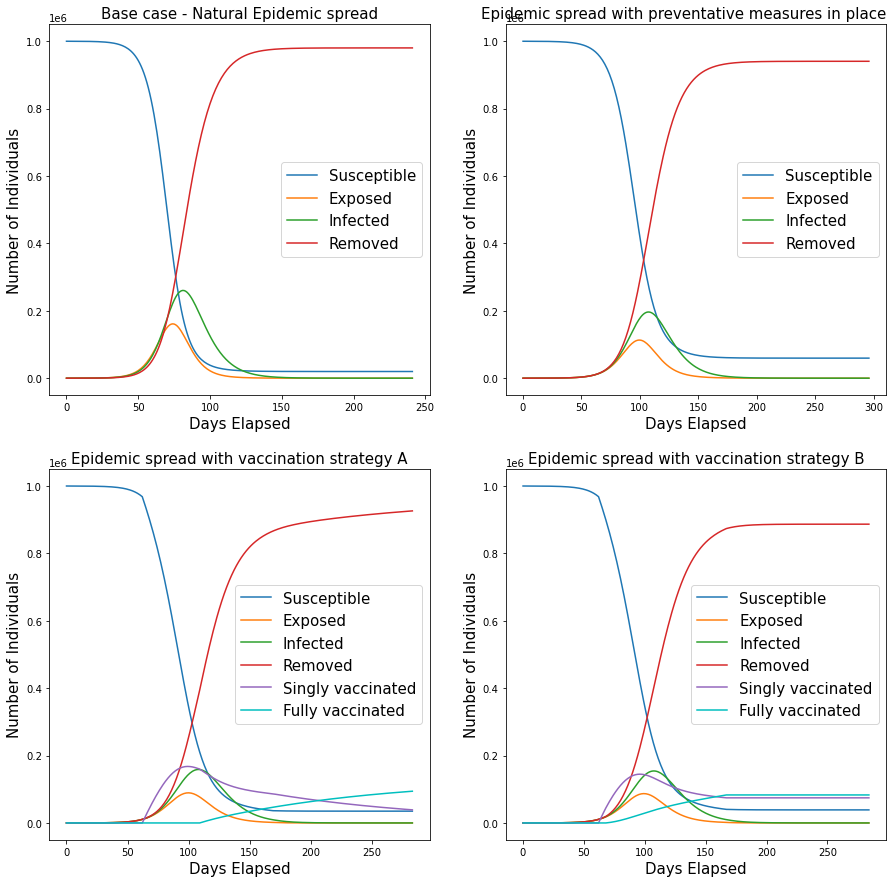

In [8]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 15)
ax1=ax[0,0]; ax2=ax[0,1]; ax3=ax[1,0]; ax4=ax[1,1]

# Base case - natural epidemic spread
ax1.plot(evolution_base['S'], label = 'Susceptible')
ax1.plot(evolution_base['E'], label = 'Exposed')
ax1.plot(evolution_base['I'], label = 'Infected')
ax1.plot(evolution_base['R'], label = 'Removed')
ax1.legend( loc = 'center right', facecolor = "white", fontsize = 15)
ax1.set_xlabel('Days Elapsed', fontsize = 15)
ax1.set_ylabel('Number of Individuals', fontsize = 15)
ax1.set_title("Base case - Natural Epidemic spread", loc="center", fontsize = 15)
ax1.set_facecolor("white")

# Epidemic spread with preventative measures in place
ax2.plot(evolution_prev['S'], label = 'Susceptible')
ax2.plot(evolution_prev['E'], label = 'Exposed')
ax2.plot(evolution_prev['I'], label = 'Infected')
ax2.plot(evolution_prev['R'], label = 'Removed')
ax2.legend( loc = 'center right', facecolor = "white", fontsize = 15)
ax2.set_xlabel('Days Elapsed', fontsize = 15)
ax2.set_ylabel('Number of Individuals', fontsize = 15)
ax2.set_title("Epidemic spread with preventative measures in place", loc="right", fontsize = 15)
ax2.set_facecolor("white")

# Epidemic spread when vaccinations are delivered according to vaccination strategy A
ax3.plot(evolution_vA['S'], label = 'Susceptible')
ax3.plot(evolution_vA['E'], label = 'Exposed')
ax3.plot(evolution_vA['I'], label = 'Infected')
ax3.plot(evolution_vA['R'], label = 'Removed')
ax3.plot(evolution_vA['V1'], label = 'Singly vaccinated')
ax3.plot(evolution_vA['V2'], label = 'Fully vaccinated', color = 'c')
ax3.legend( loc = 'center right', facecolor = "white", fontsize = 15)
ax3.set_xlabel('Days Elapsed', fontsize = 15)
ax3.set_ylabel('Number of Individuals', fontsize = 15)
ax3.set_title("Epidemic spread with vaccination strategy A", fontsize = 15)
ax3.set_facecolor("white")

# Epidemic spread when vaccinations are delivered according to vaccination strategy B
ax4.plot(evolution_vB['S'], label = 'Susceptible')
ax4.plot(evolution_vB['E'], label = 'Exposed')
ax4.plot(evolution_vB['I'], label = 'Infected')
ax4.plot(evolution_vB['R'], label = 'Removed')
ax4.plot(evolution_vB['V1'], label = 'Singly vaccinated')
ax4.plot(evolution_vB['V2'], label = 'Fully vaccinated', color = 'c')
ax4.legend( loc = 'center right', facecolor = "white", fontsize = 15)
ax4.set_xlabel('Days Elapsed', fontsize = 15)
ax4.set_ylabel('Number of Individuals', fontsize = 15)
ax4.set_title("Epidemic spread with vaccination strategy B", fontsize = 15)
ax4.set_facecolor("white")

We can see slight differences in the progression of the epidemic across the four scenarios. However, from these plots, it isn't immediately clear which vaccination strategy we should use.

As referenced in the project report, the two metrics we use to choose a vaccination strategy are the infection attack rate and the epidemic duration. Output the recorded data as a csv and analyze it in R.

In [9]:
infection_attack_rates = pd.DataFrame({'Natural_spread': iars_base, 'Preventative_measures': iars_prev, 
                                       'Vaccination_Strategy_A': iars_vA, 'Vaccination_Strategy_B': iars_vB})
epidemic_durations = pd.DataFrame({'Natural_spread': durations_base, 'Preventative_measures': durations_prev, 
                                   'Vaccination_Strategy_A': durations_vA, 'Vaccination_Strategy_B': durations_vB})

infection_attack_rates.columns.name = "Infection_Attack_Rates"
epidemic_durations.columns.name = "Epidemic_Durations"

print("dataframes have equal size:",
      len(infection_attack_rates) == len(epidemic_durations)) 
print("data size is correct:", 
      len(infection_attack_rates) == 50)

dataframes have equal size: True
data size is correct: True


In [10]:
infection_attack_rates.to_csv("Sim Outputs/inf_att.csv", index = False)
epidemic_durations.to_csv("Sim Outputs/durations.csv", index = False)